<a href="https://colab.research.google.com/github/Bharathi-Krishna/LSTM/blob/main/gan_faces_CONFIG_1_TTUR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os, random, itertools, math
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob

torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# !ls /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real
# !ls /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2

ls: cannot access '/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2': No such file or directory


In [3]:
import kagglehub

kagglehub.dataset_download(
  "xhlulu/140k-real-and-fake-faces",
)

Using Colab cache for faster access to the '140k-real-and-fake-faces' dataset.


'/kaggle/input/140k-real-and-fake-faces'

In [4]:
IMG_SIZE = 256        # Face image size
IMG_CHANNELS = 3      # RGB

## parameters
Z_DIM = 100           # G
G_HIDDEN = 64 # G
D_HIDDEN = 64 # D
BATCH_SIZE = 256 # common
G_LR = 1e-4      # Generator: Lower learning rate
D_LR = 4e-4      # Discriminator: Higher learning rate (4x)
BETAS = (0.5, 0.999) #common
EPOCHS = 20 # common


OUT_DIR = "CONFIG_1_TTUR"
os.makedirs(OUT_DIR, exist_ok=True)

In [5]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all image files
        print(f"Searching for images in: {root_dir}") # Added print statement
        self.image_files = glob.glob(os.path.join(root_dir, "*.jpg")) + \
                          glob.glob(os.path.join(root_dir, "*.jpeg")) + \
                          glob.glob(os.path.join(root_dir, "*.png"))
        print(f"Found {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, 0  # dummy label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a random image instead
            return self.__getitem__((idx + 1) % len(self.image_files))

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # [-1, 1] for RGB
])

In [10]:
data_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real"

 # <-- Update this path

train_ds = FaceDataset(data_path, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print(f"Dataset size: {len(train_ds)}, Batches: {len(train_loader)}")

Searching for images in: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real
Found 50000 images
Dataset size: 50000, Batches: 196


In [11]:
import os


print(f"Contents of {data_path}:")
try:
    for item in os.listdir(data_path):
        print(item)
except FileNotFoundError:
    print(f"Directory not found: {data_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Streaming output truncated to the last 5000 lines.
19524.jpg
47374.jpg
42311.jpg
25584.jpg
46815.jpg
68125.jpg
51544.jpg
24950.jpg
28535.jpg
37904.jpg
69385.jpg
13618.jpg
41363.jpg
52031.jpg
39816.jpg
33600.jpg
39177.jpg
59701.jpg
47787.jpg
48359.jpg
35370.jpg
05937.jpg
01959.jpg
56532.jpg
32499.jpg
07114.jpg
12219.jpg
47893.jpg
40016.jpg
33757.jpg
10367.jpg
31408.jpg
20742.jpg
53370.jpg
39880.jpg
07806.jpg
16650.jpg
53586.jpg
36475.jpg
30509.jpg
69898.jpg
11626.jpg
19639.jpg
10961.jpg
44788.jpg
64614.jpg
36884.jpg
28804.jpg
24560.jpg
33807.jpg
64647.jpg
47162.jpg
62505.jpg
59326.jpg
49337.jpg
09105.jpg
30007.jpg
11563.jpg
30601.jpg
55945.jpg
66983.jpg
60966.jpg
23178.jpg
41895.jpg
36731.jpg
41021.jpg
68486.jpg
35003.jpg
04700.jpg
19848.jpg
05000.jpg
27638.jpg
56266.jpg
59829.jpg
36127.jpg
56718.jpg
48277.jpg
23556.jpg
54086.jpg
23809.jpg
14483.jpg
14188.jpg
37081.jpg
50846.jpg
38612.jpg
01145.jpg
52325.jpg
58733.jpg
37534.jpg
44992.jpg
03961.jpg
23144.jpg
44498.jpg
32920.jpg
34813.jpg

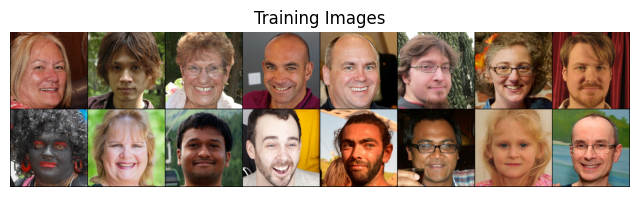

In [12]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname or "Linear" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:

class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, base=G_HIDDEN):
        super().__init__()
        # Start from 4x4 and upsample to 256x256
        self.init_size = 4
        self.linear = nn.Sequential(
            nn.Linear(z_dim, base * 8 * self.init_size * self.init_size),
            nn.BatchNorm1d(base * 8 * self.init_size * self.init_size),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            nn.Unflatten(1, (base * 8, self.init_size, self.init_size)),

            # 4x4 -> 8x8
            nn.ConvTranspose2d(base * 8, base * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(base * 4, base * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(base * 4, base * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base * 2),
            nn.ReLU(True),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(base * 2, base, 4, stride=2, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU(True),

            # 64x64 -> 128x128
            nn.ConvTranspose2d(base, base // 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base // 2),
            nn.ReLU(True),

            # 128x128 -> 256x256
            nn.ConvTranspose2d(base // 2, IMG_CHANNELS, 4, stride=2, padding=1),
            nn.Tanh()  # -> [-1,1]
        )

    def forward(self, z):
        x = self.linear(z)
        return self.conv_blocks(x)

G = Generator().to(device)
G.apply(weights_init)
G

Generator(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [15]:

class Discriminator(nn.Module):
    def __init__(self, base=D_HIDDEN):
        super().__init__()
        # For 256x256 input
        self.net = nn.Sequential(
            # 256x256 -> 128x128
            nn.Conv2d(IMG_CHANNELS, base // 2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # 128x128 -> 64x64
            nn.Conv2d(base // 2, base, 4, 2, 1),
            nn.BatchNorm2d(base),
            nn.LeakyReLU(0.2, inplace=True),

            # 64x64 -> 32x32
            nn.Conv2d(base, base * 2, 4, 2, 1),
            nn.BatchNorm2d(base * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32 -> 16x16
            nn.Conv2d(base * 2, base * 4, 4, 2, 1),
            nn.BatchNorm2d(base * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 -> 8x8
            nn.Conv2d(base * 4, base * 4, 4, 2, 1),
            nn.BatchNorm2d(base * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 -> 4x4
            nn.Conv2d(base * 4, base * 8, 4, 2, 1),
            nn.BatchNorm2d(base * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # 4x4 -> 1
            nn.Conv2d(base * 8, 1, 4, 1, 0),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x).view(-1)

D = Discriminator().to(device)
D.apply(weights_init)
D


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): L

In [16]:
opt_G = torch.optim.Adam(G.parameters(), lr=G_LR, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=D_LR, betas=BETAS)

criterion = nn.BCEWithLogitsLoss()

fixed_z = torch.randn(64, Z_DIM, device=device)  # for consistent snapshots

In [17]:
@torch.no_grad()
def save_samples(step_tag="init"):
    G.eval()
    fake = G(fixed_z).cpu()
    grid = torchvision.utils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
    torchvision.utils.save_image(grid, f"{OUT_DIR}/samples_{step_tag}.png")
    G.train()

def show_image(path):
    img = plt.imread(path)
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(img)

In [18]:

img_list = []
G_losses = []
D_losses = []

In [19]:
def save_model(epoch):
    """Saves the model and optimizer state dictionaries."""
    state = {
        'epoch': epoch,
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'opt_G_state_dict': opt_G.state_dict(),
        'opt_D_state_dict': opt_D.state_dict(),
    }
    checkpoint_filename = f"{OUT_DIR}/checkpoint_epoch_{epoch:03d}.pth"
    latest_checkpoint_filename = f"{OUT_DIR}/latest_checkpoint.pth"
    torch.save(state, checkpoint_filename)
    torch.save(state, latest_checkpoint_filename) # Save as latest checkpoint as well
    print(f"Checkpoint saved for epoch {epoch}")

In [20]:
def load_checkpoint(filepath):
    """Loads a model checkpoint and resumes training."""
    if os.path.isfile(filepath):
        print(f"Loading checkpoint '{filepath}'")
        checkpoint = torch.load(filepath)
        start_epoch = checkpoint['epoch']
        G.load_state_dict(checkpoint['G_state_dict'])
        D.load_state_dict(checkpoint['D_state_dict'])
        opt_G.load_state_dict(checkpoint['opt_G_state_dict'])
        opt_D.load_state_dict(checkpoint['opt_D_state_dict'])
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
        return start_epoch
    else:
        print(f"No checkpoint found at '{filepath}'")
        return 0 # Start from epoch 0 if no checkpoint is found

# Example usage:
# checkpoint_path = f"{OUT_DIR}/checkpoint_epoch_{EPOCHS:03d}.pth" # or the desired checkpoint
# start_epoch = load_checkpoint(checkpoint_path)

# Then modify your training loop to start from `start_epoch + 1`

In [21]:
from math import inf

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

opt_G = torch.optim.Adam(G.parameters(), lr=G_LR, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=D_LR, betas=BETAS)

criterion = nn.BCEWithLogitsLoss()

fixed_z = torch.randn(64, Z_DIM, device=device)  # for consistent snapshots


G.train(); D.train()
global_step = 0
save_samples("0000")

# Load checkpoint
checkpoint_path = f"{OUT_DIR}/latest_checkpoint.pth" # You can change the path to a specific checkpoint if needed
start_epoch = load_checkpoint(checkpoint_path)

for epoch in range(start_epoch + 1, EPOCHS + 1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for real, _ in pbar:
        real = real.to(device)  # (N,1,28,28)
        N = real.size(0)

        # -------------------------
        #  Train Discriminator
        # -------------------------
        opt_D.zero_grad(set_to_none=True)

        z = torch.randn(N, Z_DIM, device=device)
        fake = G(z).detach()

        real_logits = D(real)
        fake_logits = D(fake)

        real_labels = torch.ones(N, device=device)
        fake_labels = torch.zeros(N, device=device)

        d_loss_real = criterion(real_logits, real_labels)
        d_loss_fake = criterion(fake_logits, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # -------------------------
        #  Train Generator
        # -------------------------
        opt_G.zero_grad(set_to_none=True)

        z = torch.randn(N, Z_DIM, device=device)
        fake = G(z)
        fake_logits = D(fake)

        # want D to think fakes are real
        g_loss = criterion(fake_logits, torch.ones(N, device=device))
        g_loss.backward()
        opt_G.step()

        global_step += 1
        pbar.set_postfix(dloss=float(d_loss.item()), gloss=float(g_loss.item()))

    save_samples(f"epoch_{epoch:03d}")
    save_model(epoch) # Save model checkpoint after each epoch

No checkpoint found at 'CONFIG_1_TTUR/latest_checkpoint.pth'


Epoch 1/20: 100%|██████████| 196/196 [03:10<00:00,  1.03it/s, dloss=0.0515, gloss=8.77]


Checkpoint saved for epoch 1


Epoch 2/20: 100%|██████████| 196/196 [01:11<00:00,  2.75it/s, dloss=1.58, gloss=12.8]


Checkpoint saved for epoch 2


Epoch 3/20: 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=0.759, gloss=9.92]


Checkpoint saved for epoch 3


Epoch 4/20: 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.515, gloss=3.63]


Checkpoint saved for epoch 4


Epoch 5/20: 100%|██████████| 196/196 [01:11<00:00,  2.75it/s, dloss=0.303, gloss=9.75]


Checkpoint saved for epoch 5


Epoch 6/20: 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.273, gloss=7.06]


Checkpoint saved for epoch 6


Epoch 7/20: 100%|██████████| 196/196 [01:11<00:00,  2.72it/s, dloss=0.245, gloss=5.34]


Checkpoint saved for epoch 7


Epoch 8/20: 100%|██████████| 196/196 [01:11<00:00,  2.75it/s, dloss=0.138, gloss=4.2]


Checkpoint saved for epoch 8


Epoch 9/20: 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=0.0219, gloss=8.62]


Checkpoint saved for epoch 9


Epoch 10/20: 100%|██████████| 196/196 [01:17<00:00,  2.52it/s, dloss=0.382, gloss=10.4]


Checkpoint saved for epoch 10


Epoch 11/20: 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.0656, gloss=6.83]


Checkpoint saved for epoch 11


Epoch 12/20: 100%|██████████| 196/196 [01:11<00:00,  2.76it/s, dloss=0.104, gloss=6.46]


Checkpoint saved for epoch 12


Epoch 13/20: 100%|██████████| 196/196 [01:11<00:00,  2.75it/s, dloss=0.0648, gloss=11.6]


Checkpoint saved for epoch 13


Epoch 14/20: 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=1.54, gloss=6.73]


Checkpoint saved for epoch 14


Epoch 15/20: 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.921, gloss=6.35]


Checkpoint saved for epoch 15


Epoch 16/20: 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=0.0647, gloss=6.96]


Checkpoint saved for epoch 16


Epoch 17/20: 100%|██████████| 196/196 [01:14<00:00,  2.65it/s, dloss=0.0302, gloss=6.09]


Checkpoint saved for epoch 17


Epoch 18/20: 100%|██████████| 196/196 [01:11<00:00,  2.75it/s, dloss=0.111, gloss=9.29]


Checkpoint saved for epoch 18


Epoch 19/20: 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=0.116, gloss=5.84]


Checkpoint saved for epoch 19


Epoch 20/20: 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=0.106, gloss=5.91]


Checkpoint saved for epoch 20


Showing: samples_epoch_020.png


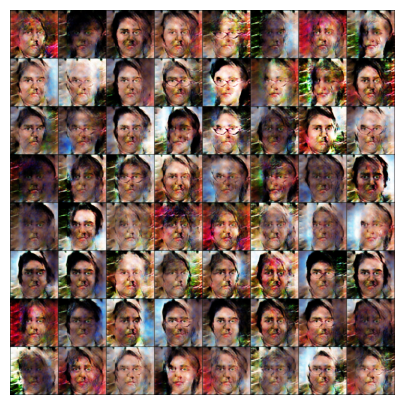

In [22]:
latest = sorted(os.listdir(OUT_DIR))[-1]
print("Showing:", latest)
show_image(os.path.join(OUT_DIR, latest))